In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib, json, os
from datetime import datetime
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    median_absolute_error
)

In [9]:
df = pd.read_csv(r'C:\Users\DELL\Desktop\AI Projects\Langchain_proj\Logistic_Agent_Planner\data\final_dataset_v1.csv')

In [10]:
df = df.drop(['route_total_duration_sec', 'route_total_distance_m','leg_base_duration_sec',
              'leg_base_distance_m','leg_total_duration_sec','leg_distance_km','leg_total_duration_hr',
              'avg_leg_speed_kmh','delay_ratio','leg_incident_length_sum_m'], axis=1)

In [11]:
target = 'route_total_with_delay_sec'
y = df[target]

# Drop columns that shouldn't be features
drop_cols = ['ts_utc', target]
X = df.drop(columns=drop_cols)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocess: One-hot encode categoricals, pass through numerics
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ])

In [12]:
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [13]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    ))
])

In [14]:

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae_seconds = mean_absolute_error(y_test, y_pred)
me_seconds = median_absolute_error(y_test, y_pred)

# Convert to minutes
mae_minutes = mae_seconds / 60
me_minutes = me_seconds / 60

# R² stays unitless (no division)
b_r2 = r2_score(y_test, y_pred)

In [15]:
mae_seconds, mae_minutes, b_r2, me_minutes

(182.41551208496094, 3.040258534749349, 0.9871156215667725, 2.685677083333333)

<Figure size 1000x600 with 0 Axes>

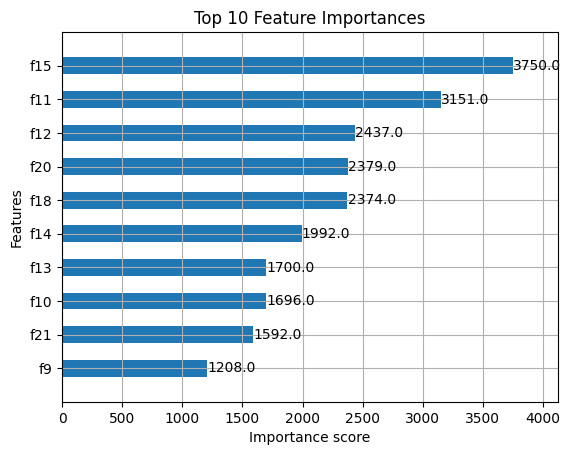

In [16]:
X_enc = preprocessor.fit_transform(X_train)
reg = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)
reg.fit(X_enc, y_train)

# Plot feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(reg, max_num_features=10, height=0.5)
plt.title('Top 10 Feature Importances')
plt.show()


In [17]:
model_DIR = "model_file_v1"
os.makedirs(model_DIR, exist_ok=True)
joblib.dump(model, f"{model_DIR}/pipeline.pkl")

['model_file_v1/pipeline.pkl']

In [18]:
preprocessor = model.named_steps["preprocessor"]
regressor = model.named_steps["regressor"]
joblib.dump(preprocessor, f"{model_DIR}/preprocessor.pkl")
joblib.dump(regressor, f"{model_DIR}/model_xgb.pkl")

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols   = X.select_dtypes(include=['int64','float64']).columns.tolist()
SAFE_FEATURES = categorical_cols + numerical_cols

with open(f"{model_DIR}/safe_features.json","w") as f:
    json.dump({"features": SAFE_FEATURES, "saved_at": datetime.utcnow().isoformat()+"Z"}, f, indent=2)

print("Saved to:", os.path.abspath(model_DIR))

Saved to: c:\Users\DELL\Desktop\AI Projects\Langchain_proj\Logistic_Agent_Planner\src\model_file_v1
